# Sample Hardness
We will look at dataset difficulty and sample hardness using Iris data

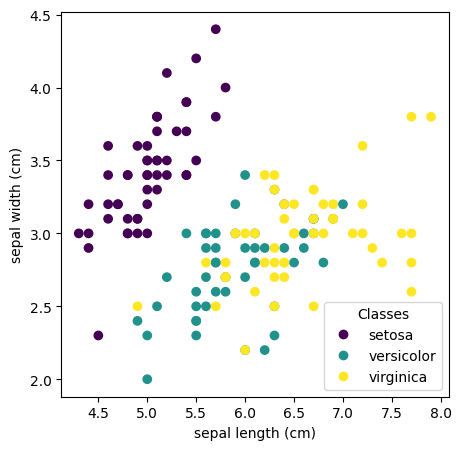

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

Iris is a relative easy dataset. We will pick two features, and pick _versicolor_ and _virginica_ lables as there seems to be some overalp in the feature space. We will look at this two dimensional data from many angles and see what can we learn about

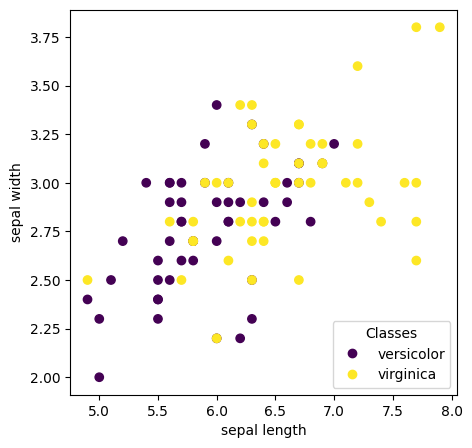

In [2]:

y = iris.target
ind = (y==1) | (y==2)
X = iris.data[ind, 0:2]
y = y[ind]-1

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set(xlabel='sepal length', ylabel='sepal width')
_ = ax.legend(
    scatter.legend_elements()[0], ['versicolor', 'virginica'], loc="lower right", title="Classes"
)

# clean up the variables

We will build a simple linear model (no interactions), then an MLP, use the Linear Model to define sample hardness.
Later, we will remove those points, and retrain an MLP. And see the difference. Along the way, we will see different sample hardness measures.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
yh_train = clf.predict(X_train)

from sklearn.metrics import classification_report
print('on train set')
print(classification_report(y_train, yh_train, target_names=['versicolor','virginica']))

yh_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_test, yh_test, target_names=['versicolor','virginica']))

on train set
              precision    recall  f1-score   support

  versicolor       0.73      0.67      0.70        33
   virginica       0.72      0.78      0.75        37

    accuracy                           0.73        70
   macro avg       0.73      0.73      0.73        70
weighted avg       0.73      0.73      0.73        70

on test set
              precision    recall  f1-score   support

  versicolor       0.81      0.76      0.79        17
   virginica       0.71      0.77      0.74        13

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.76        30
weighted avg       0.77      0.77      0.77        30



## RMD
Let us compute the Mahalanobis Distance (MD) and Relative Mahalanobis Distance (RMD) to flag RMD score

1st group (33, 2)
1st group (37, 2)


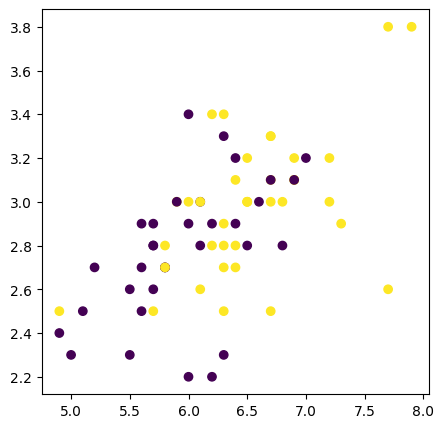

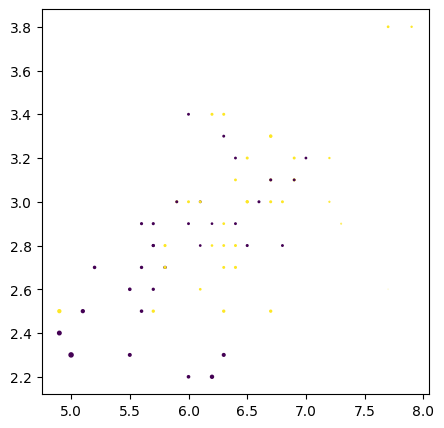

In [7]:
# let us compute RMD for this two features
from sklearn.covariance import EmpiricalCovariance, MinCovDet
X1 = X_train[y_train==0,:]
print('1st group', X1.shape)
X2 = X_train[y_train==1,:]
print('1st group', X2.shape)

Sig1 = MinCovDet().fit(X1)
Sig2 = MinCovDet().fit(X2)
Sig = MinCovDet().fit(X_train)

m1 = Sig1.mahalanobis(X_train)
m2 = Sig2.mahalanobis(X_train)
m = Sig.mahalanobis(X_train)

rmd_1 = (m1-m)
rmd_2 = (m2-m)


# take the min of m1, m2 for each record, subtract m
# min_m1_m2 = np.minimum(m1, m2)
conf_rmd  = -np.minimum(rmd_1, rmd_2)

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=np.exp(conf_rmd))


## Margins
Fit an SVM, and develop a score based on margins


In [8]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)
yh_train = clf.predict(X_train)

y_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_train, yh_train, target_names=['versicolor','virginica']))

print('on test set')
print(classification_report(y_test, yh_test, target_names=['versicolor','virginica']))

on test set
              precision    recall  f1-score   support

  versicolor       0.76      0.58      0.66        33
   virginica       0.69      0.84      0.76        37

    accuracy                           0.71        70
   macro avg       0.72      0.71      0.71        70
weighted avg       0.72      0.71      0.71        70

on test set
              precision    recall  f1-score   support

  versicolor       0.88      1.00      0.93        14
   virginica       1.00      0.88      0.93        16

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.93        30
weighted avg       0.94      0.93      0.93        30



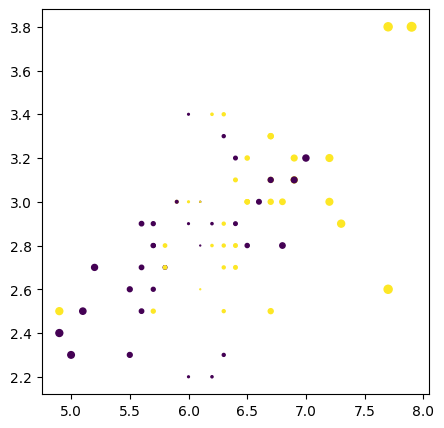

In [13]:
conf = clf.decision_function(X_train)
_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50*np.abs(conf))

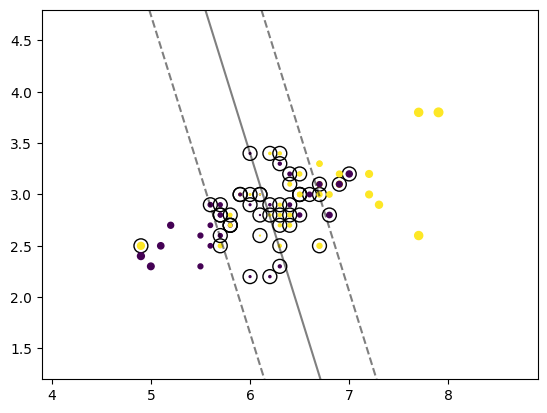

In [23]:
# plot the decision function
from sklearn.inspection import DecisionBoundaryDisplay


from sklearn import svm
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X_train, y_train)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50*np.abs(conf))
plt.show()

## Hessians and Gradients
from logistic regression